# MFPT Fault Dataset Manipulation

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_01/bin/mfpt_logo.png" width="400">

La Machinery Failure Prevention Technology es una organización orientada a la integración y al intercambio de información técnica entre distintas comunidades científicas y de ingeniería, con el fin de avanzar en el estudio de los mecánismos de falla.

https://www.mfpt.org/

En este workshop trabajaremos con su [Bearing Fault Dataset](https://www.mfpt.org/fault-data-sets/), el cual contiene mediciones experimentales de vibración de rodamientos de bola bajo distintos estados de daño. Fallas localizadas en este tipo de componentes pueden ocurrir en la ranura del anillo exterior, en la ranura del anillo interior, o bien, en alguno de los elementos rodantes del rodamiento. Cuando los elementos rodantes pasan o impactan con alguno de estos defectos, se producen vibraciones de alta frecuencia que pueden ser registradas, por ejemplo, mediante un acelerómetro o un transductor.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_01/bin/bearing_example.png" width="500">

El propósito de este dataset es propiciar la investigación y el desarrollo de modelos capaces de detectar e identificar el tipo de falla en un rodamiento, en base a las señales medidas y registradas por un transductor de vibración.

El dataset que se usará en este workshop consiste en tres señales de aceleración (g) registradas durante tres segundos (2.99 seg) a un sample rate de 4882.8 Hz sobre rodamientos NICE® a 1500 rpm. Estos registros se corresponden con tres estados de salud: `healthy`, `outer race fault`, `inner race fault`.

El dataset se encuentra en el archivo `MFPT_raw_dst.csv` contenido en el github del curso.

In [1]:
!git clone https://github.com/cherrerab/deeplearningfallas.git
%cd /content/deeplearningfallas

Cloning into 'deeplearningfallas'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 126 (delta 41), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (126/126), 959.03 KiB | 2.69 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/deeplearningfallas



---
# Exploración Inicial

Comenzemos por importar el dataset a un `pandas.DataFrame` para observar su contenido. El archivo se encuentra en el path `\content\deeplearningfallas\workshop_01\MFPT_raw_dst.csv`.

In [2]:
import numpy as np
import pandas as pd

# ubicación del dataset
dst_path = 'workshop_01//MFPT_raw_dst.csv'

# importar a un pd.DataFrame
db = pd.read_csv(dst_path)

# imprimir head del dataset (primeras 5 filas)
print( db.head(n=5) )

# imprimir cantidad de datos contenidos
print( '\nsamples: ', db.shape[0] )

# imprimir tiempo total registrado
t_total = db.iloc[-1, 0]
print( '\ntime total: {:1.7f} seg'.format(t_total) )

# imprimir time step y sample rate de la señal
t_step = np.mean( np.diff( db['Time'] ) )
print( '\ntime step: {:1.7f} seg'.format(t_step) )

sample_rate = 1.0/t_step
print( '\nsample rate: {:1.1f} Hz'.format(sample_rate) )


       Time   Healthy  Outer Race  Inner Race
0  0.000000  0.831588   -0.069897   -0.176256
1  0.000205 -1.511027   -1.207542   -0.231410
2  0.000410  1.177196   -0.403396   -1.607862
3  0.000614 -0.890607   -0.096810   -0.194259
4  0.000819 -0.658249   -0.739565    0.254521

samples:  14649

time total: 2.9999181 seg

time step: 0.0002048 seg

sample rate: 4882.8 Hz


Como se puede ver, el dataset cuenta con 14,649 samples de aceleración registrados durante 3 segundos de medición. Por supuesto, el dataset cuenta con datos de tres estados distintos de salud.

Ahora, parte importante de una buena exploración de datos consiste en visualizarlos, esto nos permitirá manejar una mejor intuición del comportamiento y los patrones que estos presenten, así como sus posibles anomalías. Para esto, usaremos principalmente `matplotlib`, la cual es una librería orientada y especializada en la creación de gráficos y visualizaciones en python.

https://matplotlib.org/

De este modo, lo primero que haremos será plotear los datos de aceleración de cada uno de los estados de aceleración en el tiempo.

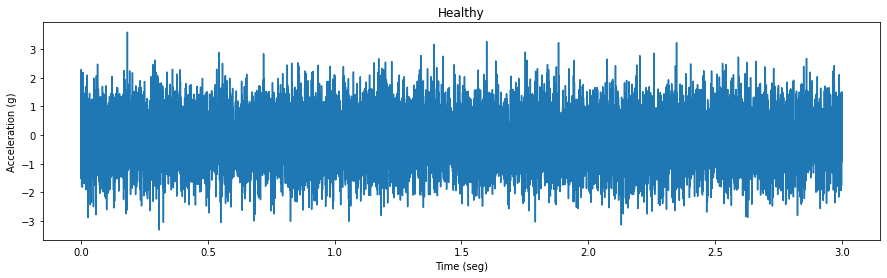

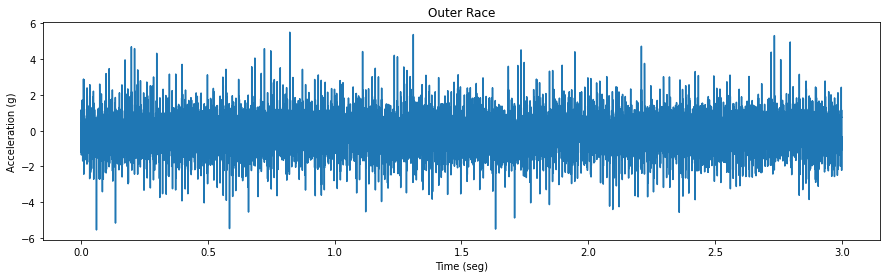

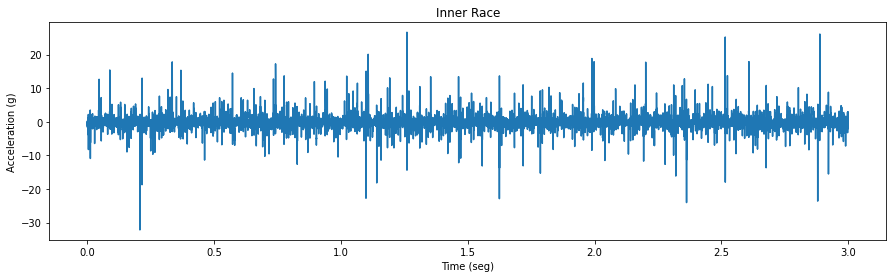

In [3]:
import matplotlib.pyplot as plt

# gráfico de estado de salud Healthy
plt.figure( figsize=(15, 4) )
plt.title('Healthy')
plt.xlabel('Time (seg)'); plt.ylabel('Acceleration (g)')

plt.plot( db['Time'], db['Healthy'])

# gráfico de estado de salud Outer Race
plt.figure( figsize=(15, 4) )
plt.title('Outer Race')
plt.xlabel('Time (seg)'); plt.ylabel('Acceleration (g)')

plt.plot( db['Time'], db['Outer Race'] )

# gráfico de estado de salud Inner Race
plt.figure( figsize=(15, 4) )
plt.title('Inner Race')
plt.xlabel('Time (seg)'); plt.ylabel('Acceleration (g)')

plt.plot( db['Time'], db['Inner Race'] )


Se puede observar que existe un diferencia evidente entre las tres señales, donde la magnitud de la aceleración es lo que cambia de forma más notoria. Podemos cuantificar esta diferencia fácilmente mediante `np.max` y `np.abs`.

In [4]:
# obtendremos la magnitud de la señal en cada sample mediante np.abs
db_abs = np.abs( db )

# de este modo, podremos obtener la amplitud máxima de cada señal
# mediante np.max o pd.DataFrame.max
print( db_abs[ ['Healthy', 'Outer Race', 'Inner Race'] ].max() )

Healthy        3.589979
Outer Race     5.547584
Inner Race    32.188190
dtype: float64


## Spectrograms

Ahora, dado que los datos consisten en señales de vibración, puede ser útil para la exploración analizar los espectrogramas de cada una. Por supuesto, en python practicamente ya está todo implementado y solo basta buscar la librería adecuada. Una rápida búsqueda por google nos lleva a `scipy.signal.spectrogram`.

<img src="https://raw.githubusercontent.com/cherrerab/deeplearningfallas/master/workshop_01/bin/scipy_badge.png" width="350">

Dado que debemos crear tres espectrogramas, uno para cada serie temporal, crearemos la función `MFPT_spectrogram` que nos permitirá repetir el proceso.

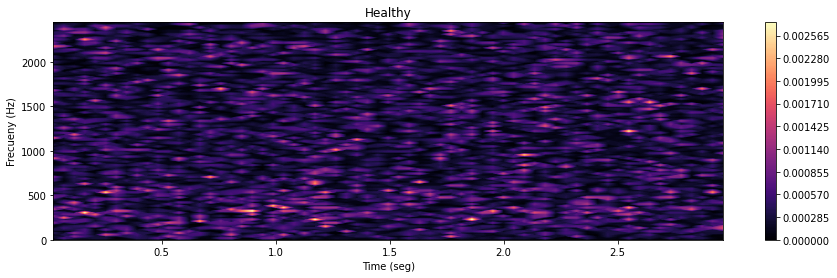

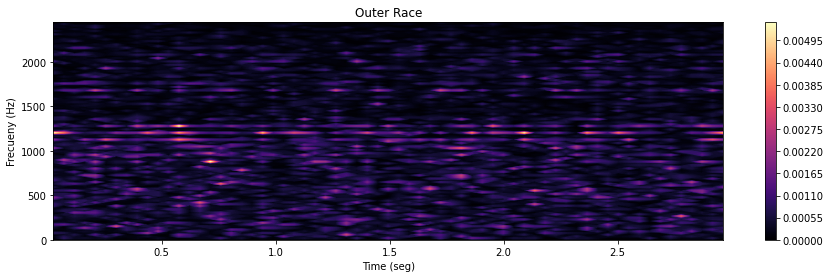

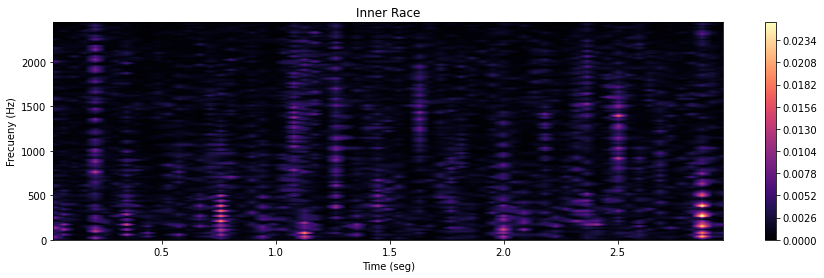

In [5]:
from scipy import signal

def MFPT_spectrogram(data, sr=1.0, nperwd=256):
  """
  -> None

  compute and plot the spectrogram of the time series.
  spectrograms can be used as a way of visualizing the change of a
  nonstationary signal’s frequency content over time.

  :param pd.Series data:
    time series of measurement values.
  :param float sr:
    sample rate of the time series data. defaults to 1.0.
  :param int nperwd:
    length of samples of each time window. defaults to 256.

  :returns:
    None
  """

  # obtener espectrograma
  freqs, times, spectrogram = signal.spectrogram(data, fs=sr, nperseg=nperwd)

  # crear meshgrid para plot
  X, Y = np.meshgrid(times, freqs)

  # configurar plot
  plt.figure( figsize=(15, 4) )
  plt.title( data.name )
  plt.xlabel('Time (seg)'); plt.ylabel('Frecueny (Hz)')

  # plot
  plt.contourf( X, Y, spectrogram, levels=256, cmap='magma')
  plt.colorbar()

  return None

# obtener espectrograma Healthy
MFPT_spectrogram(db['Healthy'], sr=sample_rate, nperwd=256)

# obtener espectrograma Outer Race
MFPT_spectrogram(db['Outer Race'], sr=sample_rate, nperwd=256)

# obtener espectrograma Inner Race
MFPT_spectrogram(db['Inner Race'], sr=sample_rate, nperwd=256)



Si bien en el caso `healthy` el espectrograma indica que la señal consiste de básicamente ruido/noise, tanto en el caso `outer race fault` como en el `inner race fault` se distinguen patrones que indican la presencia de anomalías en la señal.



---


# Training Data
Eventualmente, lo que queremos hacer con este dataset es generar un modelo de deep learning que, a partir de una muestra o sample de una señal de vibración, sea capaz de identificar el estado de salud o tipo de falla que presente el componente. Es decir un modelo de clasificación.

Ahora bien, para generar este modelo de clasificación, es necesario contar con una serie de muestras para su entrenamiento. Durante este entrenamiento, el modelo observará estas muestras e iterativamente irá ajustando sus pesos de tal manera de reducir su error de clasificación. Es de esta manera que el modelo logra aprender de los datos.


## Time Windows

En general, mientras más muestras se posea para el entrenamiento, mejor. No obstante, nunca contaremos con datasets infinitos por lo que debemos ser precavidos y eficientes respecto a como distribuimos nuestros datos. En este caso particular, contamos con tres señales finitas a partir de las cuales tendremos que extraer nuestras muestras. De este modo, nuestras muestras consistirán en ventanas de datos o tiempo, similar a como los espectrogramas anteriores procesan la información.

A continuación, definiremos la función `get_time_windows` que nos permita extraer las ventanas de tiempo de una serie de datos, en función de un tamaño de ventana `nperwd` definido.

time windows generated: 114


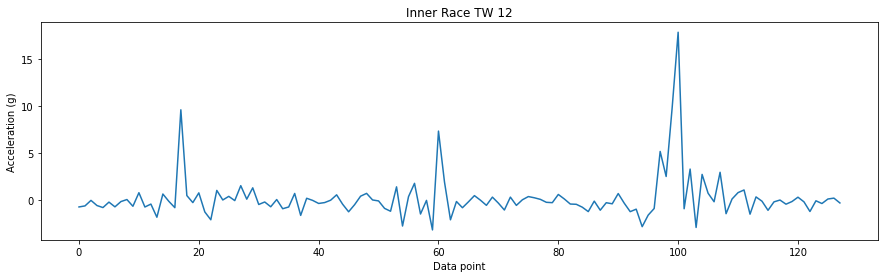

In [6]:
def get_time_windows(data, nperwd):
  """
  -> np.array

  generates a numpy array of time windows, of length nperwd, extracted
  from data.

  :param pd.Series data:
    time series of measurement values.
  :param int nperwd:
    length of samples of each time window.
  :param int overlap:
    length of overlap between time windows.

  :returns:
    a numpy array of size (n_windows, nperwd).
  """

  # obtener np.array de la serie de datos
  x = data.values

  # determinar cantidad de ventanas a generar
  n_windows = x.size//nperwd

  # generar time windows
  out = np.reshape( x[0:n_windows*nperwd], (n_windows, nperwd) )

  return out

# generar ventanas a partir de los datos Inner Race
X_IR = get_time_windows( db['Inner Race'], nperwd=128 )

print('time windows generated: {:d}'.format(X_IR.shape[0]))

# plot muestra de ventana
x = X_IR[12, :]

plt.figure( figsize=(15, 4) )
plt.title('Inner Race TW 12')
plt.xlabel('Data point'); plt.ylabel('Acceleration (g)')
plt.plot( x )

Una pregunta que nos podríamos hacer ahora, es respecto a de qué tamaño deben ser estas ventanas. La intuición nos indica que mientras más ventanas generemos, mejor será nuestro entrenamiento. No obstante, si definimos `nperwd` muy pequeño es posible que nuestras ventanas no contengan suficiente información.

De esta manera, debemos encontrar un `nperwd` que logre un buen balance entre la cantidad de ventanas o samples generados, y la cantidad de información que estos contengan. Por supuesto, una forma de hacer esto es mediante prueba y error, pero también es posible explorar métodos un tanto más sistemáticos.

Dado que este es el primer workshop del curso, nos limitaremos a definir el `nperwd` que nos parezca adecuado, por ejemplo, `48`. Ahora crearemos el `training set` para nuestro modelo, utilizando las tres señales de vibración.

In [7]:
# definir tamaño de ventanas
nperwd = 48

# generar ventanas a partir de los datos Healthy
X_HB = get_time_windows( db['Healthy'], nperwd=nperwd )

# generar ventanas a partir de los datos Outer Race
X_OR = get_time_windows( db['Outer Race'], nperwd=nperwd )

# generar ventanas a partir de los datos Inner Race
X_IR = get_time_windows( db['Inner Race'], nperwd=nperwd )

# finalmente, concatenar estas ventanas mediante np.vstack
X_raw = np.vstack( [X_HB, X_OR, X_IR] )

print('number of samples: ', X_raw.shape[0])
print('samples length: ', X_raw.shape[1])


number of samples:  915
samples length:  48


Por supuesto, como nuestro modelo debe aprender a clasificar el estado de salud de nuetros `samples`, debemos crear un `np.array` `target` que contenga las etiquetas de nuestras muestras.

In [9]:
# generar np.array Y con las etiquetas correspondientes
labels = [0]*X_HB.shape[0] + [1]*X_OR.shape[0] + [2]*X_IR.shape[0]
labels = np.array( labels )

# reshape a dimensiones compatibles con X_raw
Y = labels.reshape( (-1, 1) )


## Feature Extraction

Hasta este punto, salvo quizás por los espectrogramas, nos hemos limitado a utilizar únicamente los datos puros o `raw`. No obstante, en Machine Learning, es común preprocesar los datos antes de entrenar los modelos y no utilizar los datos en `raw`. El objetivo de esto es extraer `features` y valores que sean más efectivos a la hora del entrenamiento.

Para introducir esta etapa de preprocesamiento, definiremos la función `extract_features`. Esta función procesará las ventanas de datos generadas en la sección anterior, y calculará algunas `features` características de señales de vibración: `rms`, `peak`, `valley`, `peak2peak`.



In [10]:
def extract_features(x):
  """
  -> pd.DataFrame

  compute signal features for each sample in the data x.

  :param np.array x:
    data of shape (n_samples, nperwd) containing de samples.

  :returns:
    pd.DataFrame of shape (n_samples, n_features) containing
    the extracted features.
  """
  
  # valor eficaz rms
  rms = np.sqrt( np.mean( np.square(x), axis=1 ) )
  rms = rms.reshape( (-1, 1) )

  # peak
  peak = np.max( x, axis=1 )
  peak = peak.reshape( (-1, 1) )

  # valley
  valley = np.min( x, axis=1 )
  valley = valley.reshape( (-1, 1) )

  # peak2peak
  peak2peak = np.abs( peak - valley )
  peak2peak = peak2peak.reshape( (-1, 1) )

  # concatenar features
  out = np.hstack( [rms, peak, valley, peak2peak] )

  # generar pd.DataFrame
  db = pd.DataFrame(out, columns=['rms', 'peak', 'valley', 'peak2peak'])

  return db

# generar dataset de features a partir de X_raw
db_ft = extract_features(X_raw)

print(db_ft.head(n=5))

# obtener X_features
X_features = db_ft.values

        rms      peak    valley  peak2peak
0  1.065073  2.287067 -1.817122   4.104189
1  0.912058  1.688415 -1.911052   3.599467
2  0.993600  2.095749 -2.879812   4.975561
3  0.850362  1.457116 -2.430836   3.887952
4  0.766862  1.260137 -2.350270   3.610407


Finalmente, podemos visualizar la distribución que presentan estos features en cada uno de los estados, para hacernos una idea de que tan útiles podrían resultar para el entrenamiento.

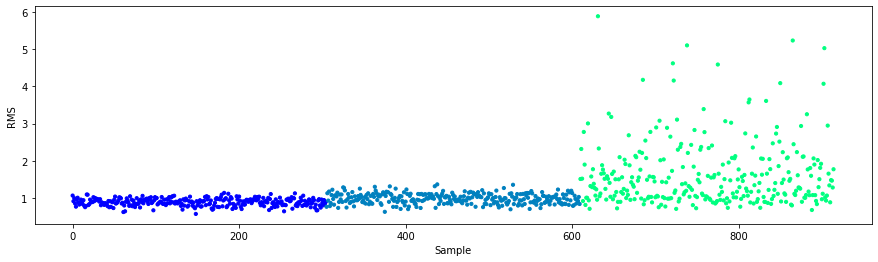

In [11]:
# scatter plot RMS
plt.figure( figsize=(15, 4) )
plt.xlabel('Sample'); plt.ylabel('RMS')

plt.scatter(db_ft.index, db_ft['rms'],
            c=list(labels), s=10, cmap='winter')